In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


[0.3        0.29393939 0.28787879 0.28181818 0.27575758 0.26969697
 0.26363636 0.25757576 0.25151515 0.24545455 0.23939394 0.23333333
 0.22727273 0.22121212 0.21515152 0.20909091 0.2030303  0.1969697
 0.19090909 0.18484848 0.17878788 0.17272727 0.16666667 0.16060606
 0.15454545 0.14848485 0.14242424 0.13636364 0.13030303 0.12424242
 0.11818182 0.11212121 0.10606061 0.1        0.09393939 0.08787879
 0.08181818 0.07575758 0.06969697 0.06363636 0.05757576 0.05151515
 0.04545455 0.03939394 0.03333333 0.02727273 0.02121212 0.01515152
 0.00909091 0.0030303  0.0030303  0.00909091 0.01515152 0.02121212
 0.02727273 0.03333333 0.03939394 0.04545455 0.05151515 0.05757576
 0.06363636 0.06969697 0.07575758 0.08181818 0.08787879 0.09393939
 0.1        0.10606061 0.11212121 0.11818182 0.12424242 0.13030303
 0.13636364 0.14242424 0.14848485 0.15454545 0.16060606 0.16666667
 0.17272727 0.17878788 0.18484848 0.19090909 0.1969697  0.2030303
 0.20909091 0.21515152 0.22121212 0.22727273 0.23333333 0.239393

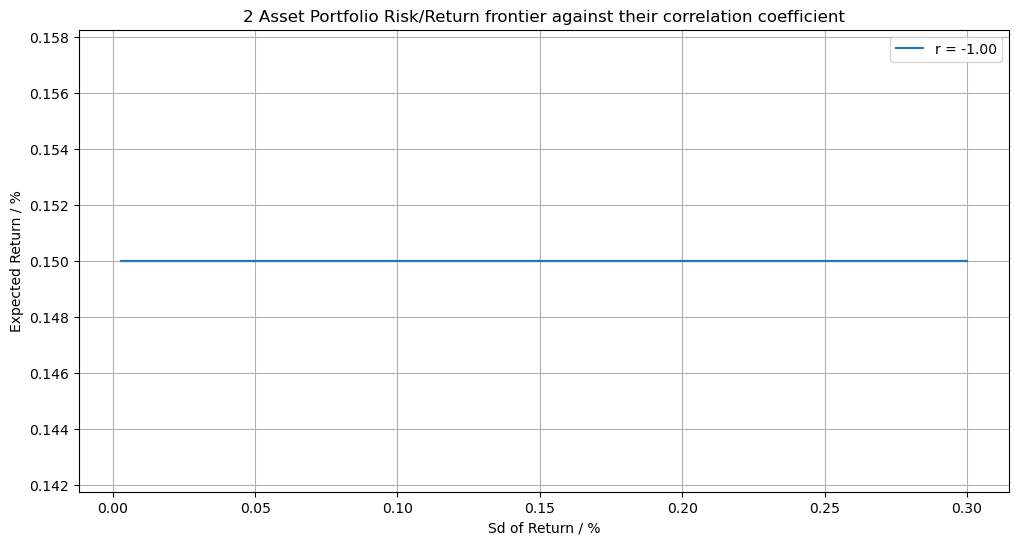

In [18]:

def display_frontier():
    # settings
    Er1, Sd1 = 0.15, 0.3
    Er2, Sd2 = 0.15, 0.3
    # correlation = np.linspace(-1, 1, 10)
    correlation = [-1]

    # parameterized
    # w1 = np.linspace(-1, 1, 100)

    figure = plt.figure(figsize=(12, 6))
    ax = plt.gca()
    for c in correlation:
        # find minimal variance portfolio weight
        # optimal = (Sd2 ** 2 - c * Sd1 * Sd2) / (Sd1 ** 2 + Sd2 ** 2 - 2 * c * Sd1 * Sd2)
        w1 = np.linspace(0, 1, 100)

        Er = w1 * Er1 + (1-w1) * Er2
        Sd = np.sqrt(w1**2*Sd1**2+(1-w1)**2*Sd2**2+2*w1*(1-w1)*c*Sd1*Sd2)
            
        print(Sd)      
        print(w1)      
        
        ax.plot(Sd, Er, label=f"r = {c:.2f}")

    # figure.show()
    ax.legend()
    ax.grid()
    ax.set_title("2 Asset Portfolio Risk/Return frontier against their correlation coefficient")
    ax.set_ylabel("Expected Return / %")
    ax.set_xlabel("Sd of Return / %")



display_frontier()

In [40]:
# historical data analysis
import os

# download 5Y data from yahoo!finance


def download_data(names):
    for name in names:
        if os.path.isfile(f'asx20\\{name}.AX.csv'):
            print(f'skipping {name}')
            continue

        print(f'downloading {name}')
        text = f'curl "https://query1.finance.yahoo.com/v7/finance/download/{name}.AX?period1=1522713600&period2=1680480000&interval=1d&events=history&includeAdjustedClose=true" > asx20\\{name}.AX.csv'
        os.system(text)
        print(f'done {name}')

    print('finished')
    
names = ['ASX', 'BHP', 'CBA', 'CSL', 'NAB', 'WBC', 'ANZ', 'MQG', 
         #'FMG', 
         'WDS', 'WES', 'TLS', 'WOW', 'RIO', 'TCL', 'GMG', 'ALL', 'COL', 'NCM', 'STO', 
         #'WTC'
        ]
# as of today
market_caps = [
    338.793e9,
    167.467e9,
    140.326e9,
    87.611e9,
    76.529e9,
    69.738e9,
    48.411e9,
    #69.246e9,
    64.994e9,
    58.064e9,
    48.671e9,
    46.445e9,
    192.7e9,
    44.021e9,
    36.413e9, #GMG
    24.722e9,
    24.185e9,
    24.01e9,
    23.425e9,
    #21.925e9
]
# download_data(names)
len(market_caps)


18

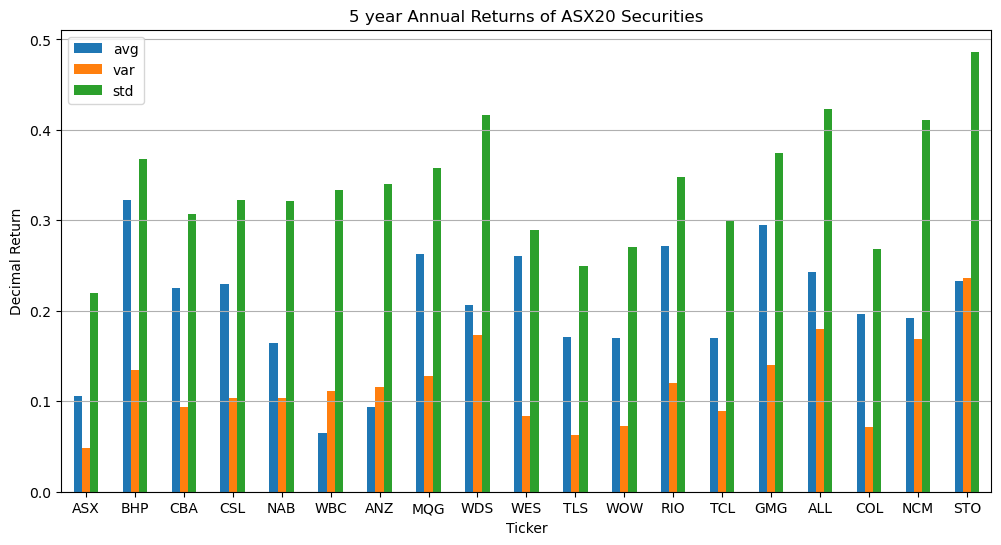

In [56]:

def process_data(name):
    df = pd.read_csv(f"asx20/{name}.AX.csv",
                     parse_dates=['Date'], index_col=['Date'])
    return df[['Adj Close']]

def join_df(names):
    df = None
    for name in names:
        closes = process_data(name)
        closes.rename(columns={'Adj Close': name}, inplace=True)

        if df is None:
            df = closes
        else:

            df = df.join(closes)

    return df


def stats_df(df):
    df = df.dropna()

    names = df.columns
    # return_names = list(map(lambda n: n + ' return', names))
    # joined = []
    # for n, rtn in zip(names, return_names):
    #     joined.append(n)
    #     joined.append(rtn)
    #     df = df.join(diff)

    # returns = df[joined]

    # Compute Returns Dataframe
    df_returns = df.pct_change()
    
    #df_returns = np.log(df) - np.log(df.shift(1))
    df_returns.dropna()
    # Compute stats
    avgs = []
    vars = []
    stds = []
    # data = {}
    for column in df:
        #print(column)
        returns = df_returns[column]
        avg = returns.mean()
        var = returns.var()
        std = returns.std()

        avgs.append(avg*365)
        #print(avgs[-1])
        vars.append(var*365)
        stds.append(std*np.sqrt(365))

    df_stats = pd.DataFrame({
            'avg': avgs,
            'var': vars,
            'std': stds,
        },
        index=names
    )

    df_covariance = df_returns.cov() * 365

    # beta = cov/var(m)
    betas = df_covariance['ASX'] / df_stats.loc['ASX', 'var']
    df_beta = pd.DataFrame(
        {
            'beta': betas
        },
        index=names
    )
    
    
    return df_returns, df_stats, df_covariance, df_beta

def mc_df(mc, df):
    df = pd.DataFrame(
        {
            'market cap': mc
        },
        index=df.columns[1:]
    )

    df['weighted'] = df['market cap'] / df['market cap'].sum()
    return df

df = join_df(names)
df_returns, df_stats, df_cov, df_beta = stats_df(df)
df_mc = mc_df(market_caps, df)

def plot_stats(stats):
    ax = stats.plot.bar(rot=0, figsize=(12, 6))
    ax.grid(axis='y')
    ax.set_xlabel("Ticker")
    ax.set_ylabel("Decimal Return")
    ax.set_title("5 year Annual Returns of ASX20 Securities")


# df_stats
#df_returns
plot_stats(df_stats)

In [5]:
# Copied from: https://stackoverflow.com/a/64430840

def generate_weights0( layers = 4, tgt = 100 ):
    """ Generate list of lists with 'layers' items adding to tgt """
    result = []

    def one_layer( layers, tgt, cumul ):
        """  layers: layers still to produce.
             tgt: the tgt still left to be consumed.
             cumul: a list of the combinations for the layers already processed.
        """
        if layers == 1: # return results for the last layer
            cumul.append( tgt )
            result.append( cumul )
        else:
            # For each i call one_layer with revised parameters
            for i in range( tgt + 1 ):
                cumul_ = cumul.copy()
                cumul_.append( i )
                # Recursive call with updated parameters
                one_layer( layers - 1, tgt - i, cumul_ )

    one_layer( layers, tgt, [] )  # Execute the initialised function
    return np.array( result )

def generate_weights( layers = 4, min_ = 0, tgt = 100 ):
    tgt = tgt - ( layers * min_ )
    return generate_weights0( layers, tgt ) + min_

def grid(n):
    return generate_weights(n, 0, 10) / 10



In [6]:
from sympy.utilities.iterables import partitions
from more_itertools import distinct_permutations
# if you don't want to install more_itertools:
#     set(itertools.permutations( ... ))
#     is equivalent but less efficient than
#     more_itertools.distinct_permutations( ... )
from collections import Counter  # not really needed; just for .elements()

def create_weights(dim, grid):
    for p in partitions(grid, m=dim):
        p[0] = dim - sum(p.values())
        yield from (distinct_permutations(x / grid for x in Counter(p).elements()))


In [7]:
len(list(create_weights(20, 6)))

177100

In [8]:
df_cov.iloc[2, 1]

0.045830542575696645

In [9]:
cov = df_cov.iloc[1:, 1:].to_numpy()

cov[1][0]

0.045830542575696645

In [ ]:


# df_returns, df_stats, df_cov, df_beta, df_mc
market = (df_returns, df_stats, df_cov, df_beta, df_mc)

def plot_cml_ef(market):

    df_returns, df_stats, df_cov, df_beta, df_mc = market

    # plot EF, (SD, AvgRet)


    # plot portfolio with all weightings
    tickers = len(df_returns.columns) - 1
    # print(tickers)
    # return 0
    d = 15
    #weights = list(create_weights(tickers, d))
    total = 1
#     print(total)
    #del weights

    rets = np.zeros(total)
    stds = np.zeros(total)

    # return 0
    # for each portfolio weight
    cov = df_cov.iloc[1:, 1:].to_numpy()
    stat = df_stats.iloc[1:1+tickers, 0].to_numpy()
    for z, weight in enumerate(create_weights(tickers, d)):
        # if np.array(weight).std() > 0.1:
        #     continue
        
        #print(f'completed {z / total:.2f}', end='\r')
        # calculate portfolio return
        rets[0] = np.dot(weight, stat)
        # for i in range(tickers):
        #     ret += weight[i] * stat[i]
        # if ret >  0.5:
        #     print(weight)

        # calculate portfolio variance
        stds[0] = np.sqrt(np.dot(weight, cov @ weight))
        
        
        if abs(rets[0] - 0.297) < 0.001 and abs(stds[0] - 0.26 < 0.001):
            print(weight)
        # for i in range(tickers):
            # for j in range(tickers):
                # var += weight[i] * weight[j] * cov[i,j]

    
    fig = plt.figure(figsize=(12, 6))
    ax = plt.gca()

    ax.scatter(stds, rets)
    ax.set_xlim(0, 0.6)
    ax.set_ylim(0, 0.5)
    ax.set_xlabel('Risk / SD')
    ax.set_ylabel('Expected Return / 100%')



    # 5 year bond yield
    # https://au.investing.com/rates-bonds/australia-5-year-bond-yield
    bond_yield = 3.071 / 100
    
    return rets, stds

ef_rets1, ef_stds2 = plot_cml_ef(market)



(0.5333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.06666666666666667, 0.0, 0.0)
(0.4666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0)
(0.4666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13333333333333333, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.06666666666666667, 0.0, 0.0)
(0.4666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0)
(0.4666666666666667, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0)
(0.4666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0)
(0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26666666666666666, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0)
(0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0, 0.0, 0.0666666666

In [64]:
# get market portfolio value
def market_portfolio(market):
    df_returns, df_stats, df_cov, df_beta, df_mc = market
    
    weight = df_mc['weighted'].to_numpy()
    cov = df_cov.iloc[1:, 1:].to_numpy()
    stat = df_stats.iloc[1:21, 0].to_numpy()
    betas = df_beta['beta'].to_numpy()
    
    ret = np.dot(weight, stat)
    std = np.sqrt(np.dot(weight, cov @ weight))
    beta = np.dot(weight, betas[1:])
    return ret, std, beta

market_portfolio(market)

(0.2334616256570802, 0.23644734566029502, 1.017049424718656)

In [59]:
def get_yield():
    df = pd.read_csv(f"data/5ybonds.csv",
                     parse_dates=['Date'], index_col=['Date'])
    
    return df['Price'].mean()

get_yield()
    

C:\Users\forti\AppData\Local\Temp\ipykernel_4848\4274086666.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df = pd.read_csv(f"data/5ybonds.csv",


1.593275

In [70]:
def test_weights(weights, market):
    df_returns, df_stats, df_cov, df_beta, df_mc = market
    
    cov = df_cov.iloc[1:, 1:].to_numpy()
    stat = df_stats.iloc[1:21, 0].to_numpy()
    betas = df_beta['beta'].to_numpy()
    
    ret = np.dot(weights, stat)
    std = np.sqrt(np.dot(weights, cov @ weights))
    beta = np.dot(weights, betas[1:])
    return ret, std, beta

    
ws = (0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0)
test_weights(ws, market)

(0.29720607918613623, 0.26135641534363735, 1.0241247862122917)

In [ ]:
# conclusion
# using ASX200 as market, top 20 firms (excluding outliers) as all available shares
# using rf = 1.59
# predicted rm = (0.233, 0.236), got = (0.26, 0.297)
# predicted bm = 1, market cap = 1.017, portfolio = 1.024
# market cap weights
# 0.223, 0.110, 0.0925, 0.0578, 0.0505, 0.0460, 0.0319, 0.0429, 0.0383, 0.0321, 0.0306, 0.127, 0.0290, 0.0240, 0.0163, 0.0159, 0.0158, 0.0154
# 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0

# comments
# requires more samples in the EF process
# need more shares (200 needed), more efficient EF calculation
# decide between return rate format
# consider the risk free rate used here

In [74]:
str(list(df_mc['weighted'].to_numpy()))

'[0.2234008671139612, 0.11042811691201926, 0.09253128039432254, 0.0577708906875917, 0.050463394932493695, 0.04598539424012133, 0.031922322414731044, 0.042857189957303705, 0.03828753235192298, 0.0320937670002143, 0.03062593758757686, 0.12706681393316957, 0.029027546529071396, 0.024010814196930484, 0.016301742470450537, 0.01594764346120242, 0.015832248067127148, 0.015446497749789815]'